# **Character Level Language Model**
Dato un file di test, ogni parola o frase viene trattata come una sequenza di caratteri.<br>
L'obbiettivo è di modellare le seguenze di caratteri per capire come prevedere il prossimo carattere nella sequenza.
Il Character Level Language Model prevede il prossimo carattere in una sequenza dati una serie di caratteri prima di esso

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('./data/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### **1. Bi-Grammi**

In [3]:
# Iniziamo da un Bi-grams Language Model, il modello più semplice che dato un carattere, predice il carattere successivo

for w in words[:3]: # per ogni parola guardiamo 2 caratteri consecutivi alla volta
    chs = ['<S>'] + list(w) + ['<E>'] # vogliamo predire anche il carattere dato l'inizio e la conclusione dato un carattere
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


#### Approccio 1: Conteggio Sequenze

In [4]:
# in questo caso il modo più semplice per predire quale carattere segua un certo carattere è il conteggio: quante volte una combinazione avviene nel set di allenamento
# abbiamo quindi bisogno di un dizionario che tenga conto di ogni coppia di caratteri che appare nel set
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1  # conteggio occorrenza bigrammi

In [5]:
sorted(b.items(), key = lambda kv: -kv[1]) 
# vediamo che quando abbiamo a oppure n, è molto probabile che essi siano caratteri finali

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [6]:
import torch

In [7]:
# Un alternativa migliore rispetto al dizionario è utilizzare una matrice dove le righe indicano il primo carattere della sequenza e le colonne il secondo, 
# il valore rappresenta il numero di volte che la combinazione appare
# per questa task utilizziamo tensor in quanto ci permette di manipolare le singole caselle efficientemente

N = torch.zeros((27,27), dtype=torch.int32) # abbiamo 26 lettere dell'alfabeto e un carattere speciale che indica inizio o fine stringa

chars = sorted(list(set(''.join(words)))) # lista di lettere dell'alfabeto
stoi = {s:i+1 for i,s in enumerate(chars)} # mappiamo il carattere all'integer data la numerazione della lista di lettere
stoi['.'] = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

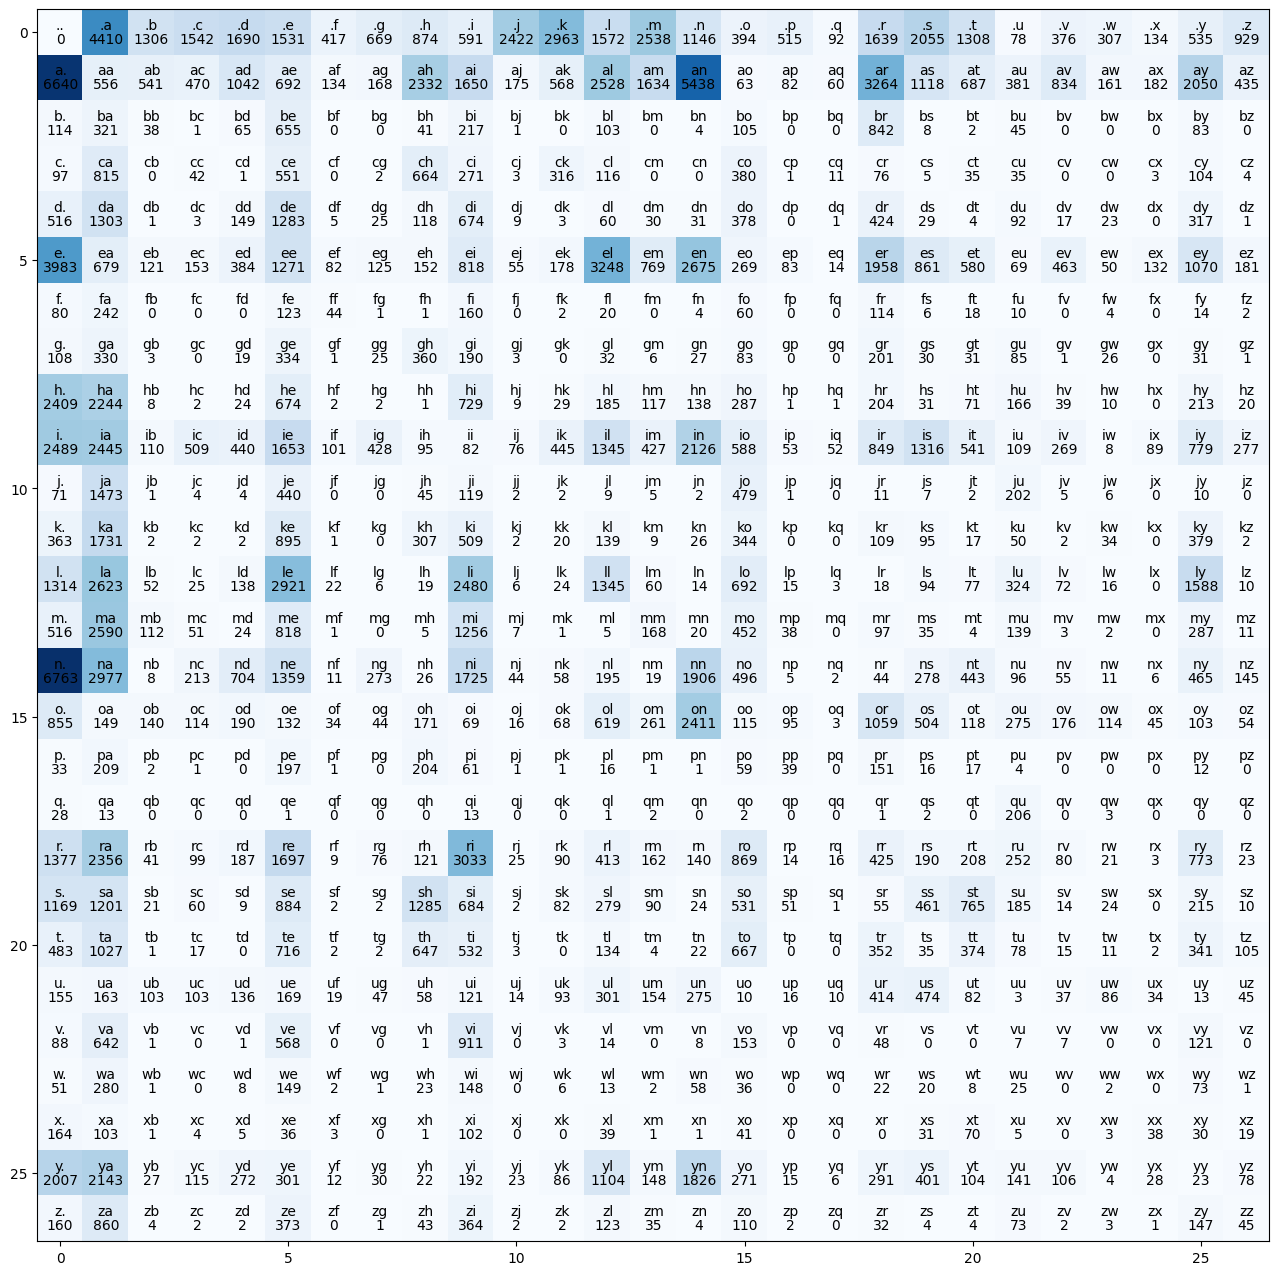

In [8]:
# Visualizziamo la matrice:
itos = {i:s for s,i in stoi.items()} # mappiamo gli interi nelle lettere

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr, ha="center", va="bottom")
        plt.text(j,i,N[i,j].item(), ha="center", va="top")


In [9]:
# Quello che vogliamo fare ora è creare un modello che predica la lettera successiva:
# per fare ciò, calcoliamo la distribuzione di probabilità per una lettera x
N[0, :]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [10]:
p = N[0,:].float()
p = p/p.sum()
p # la probabilità per ogni carattere di seguire il carattere x=0 che in questo caso è il carattere speciale .

# campioniamo il possibile successore da questa distribuzione di probabilità:
ix = torch.multinomial(p, num_samples=1, replacement=True).item()
itos[ix] # otteniamo il carattere rispettivo

P = (N+1).float() # rappresenta la matrice di distribuzione probabilità, aggiungere 1 assicura che non otteniamo nessuna combinazione con probabilità 0
P = P / P.sum(1, keepdim=True) # dividiamo ogni cella per la somma delle celle in una riga per ottenere le probabilità
# è importante mantenere la dimensionalità in quanto altrimenti l'operazione sarebbe dividere (27,27) con (27) e in questo caso trasformerebbe il vettore in (1,27) al posto di (27,1)

In [11]:
# Possiamo svolgere questo processo per più volte in modo da ottenere una parola completa:
ix = 0
for i in range(10):
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True).item() # campionamente per ottenere successore
        if (ix==0): # se è 0 vuol dire che la parole è terminata
            break
        out.append(itos[ix])

    print(''.join(out))

# Otteniamo nomi abbastanza strani ma questo è normale in quanto un language model basato su bi-grammi si basa soltanto sull'ultimo carattere, non è quindi molto preciso
# Possiamo notare che in ogni caso il modello è migliore del modello base dove ogni carattere ha la stessa probabilità

xlm
ran
ch
munaloonla
ma
smatanauslllaienoralyogiaynembayl
gacahenan
eyaiee
n
gnchi


#### Bontà del Modello

In [12]:
# Cerchiamo di valutare la bontà del modello -> loss function
# Guardiamo la probabilità con cui il modello assegna il carattere seguente corretto nel testo su cui abbiamo allenato il modello:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2} :{prob:.4f}')
# queste probabilità sono un modo per valutare l'efficacia del modello di predirre il carattere seguente, il nostro obbiettivo sarebbe ottenere valori più simili possibile a 1

.e :0.0478
em :0.0377
mm :0.0253
ma :0.3885
a. :0.1958
.o :0.0123
ol :0.0779
li :0.1774
iv :0.0152
vi :0.3508
ia :0.1380
a. :0.1958
.a :0.1376
av :0.0246
va :0.2473
a. :0.1958


In [13]:
# come possiamo rappresentare queste probabilità in un singolo numero che rappresenta la bontà del modello?
# utilizziamo il likelihood -> il prodotto di tutte le probabilità, ci dice la probabilità che l'intero dataset venga predetto correttamente dal modello.
# più questo valore è alto, più il modello è capace di predirre correttamente il prossimo carattere
# per convenienza utilizziamo il log-likelihood in quanto esso ha valori nel range [-inf, 0] e tramite le proprietà del logaritmo, il prodotto si trasforma in somma
log_likelihood = 0.0
n = 0
for w in words[:5]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2} :{logprob:.4f}')

print(log_likelihood) # per ottenere stime più precise dobbiamo massimizzare il log_likelihood (portarlo a 0)
# dato che la loss function va minimizzata, utilizziamo il log likelihood negativo come misura
nll = - log_likelihood # ottima loss function in quanto il valore minimo è 0 e più alto è il valore, peggiore è il modello, il nostro obbiettivo è minimizzarlo
nll/n # standardizzato in modo da non ottenere valori troppo grandi

tensor(-77.8251)


tensor(2.4320)

#### Approccio 2: Reti Neurali

In [14]:
# utilizziamo le reti neurali per predirre i bi-grammi
# abbiamo già trovato una funzione per che valuta la bontà del modello: negative log-likelihood,
# possiamo utilizzarla per fare fine-tuning dei pesi fino ad ottenere delle predizioni soddifacenti

# La rete neurale riceverà in input un carattere e dei parametri (pesi) e ritornerà in output il carattere che è probabile segua il primo

In [15]:
# Creiamo il training set di bigrammi:
xs, ys = [], [] # ad ogni x (primo carattere) corrisponde una y (il carattere che segue)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [16]:
# abbiamo bisogno di codificare gli input, dato che dare in input ad una rete neurale interi non è corretto (valuterebbe 12 simile a 13 quando in realtà sono 2 lettere differenti)
# per fare ciò utilizziamo il one-hot encoding
import torch.nn.functional as F
x_enc = F.one_hot(xs, num_classes=27).float() # cast a float in modo che possa essere utilizzato come input di una rete neurale
#plt.imshow(x_enc)

In [17]:
W = torch.randn((27,27)) # inizializziamo i pesi della rete casualmente seguendo una distribuzione normale
# questi pesi vengono poi moltiplicati con l'input:
x_enc @ W   # @ è un operatore per la moltiplicazione di matrici in pyTorch, in questo caso (5,27) @ (27,27) = (5,27)
# per ognuno dei 27 neuroni di input (uno per carattere) qual'è il punteggio assegnato dati i 5 esempi

tensor([[ 1.4815e-01, -4.0021e-01, -1.4664e+00,  ...,  8.8418e-01,
         -1.5111e+00, -1.7943e+00],
        [-1.4972e+00,  4.9752e-01,  3.4703e-01,  ...,  3.7118e-01,
          1.3574e+00,  3.6233e-01],
        [ 5.9792e-01, -6.0923e-01, -1.9573e+00,  ..., -1.4079e+00,
          5.4521e-01, -2.0331e+00],
        ...,
        [ 3.3790e-01,  1.0013e+00,  3.8062e-04,  ..., -8.1416e-01,
          9.5091e-01, -4.4667e-01],
        [ 1.0793e+00,  2.2124e+00,  6.8664e-01,  ..., -1.1420e+00,
          3.5241e-01,  1.2161e-01],
        [-1.7839e+00,  9.5717e-02,  1.1857e-02,  ..., -5.6603e-02,
         -1.0536e-04,  2.1938e+00]])

In [18]:
# SOFTMAX: utilizzato nelle reti neurali per ottenere come risultato una distribuzione di probabilità
# interpretiamo i valori come se fossero logaritmi e li eleviamo a esponenziale, in questo modo i numeri negativi diventano positivi <1 e i numeri positivi diventano >1
counts = (x_enc @ W).exp() # in questo modo la rete neurale predice conteggi, equivalente alla matrice N
probs = counts / counts.sum(1, keepdim=True) # le probabilità sono i conteggi normalizzati
# esempio:abbiamo il carattere '.', abbiamo ottenuto il suo indice, lo abbiamo codificato, lo abbiamo mandato in input alla rete ed è venuta fuori la distribuzione di probabilità 
probs[0] # interpretiamo questo vettore come le probabilità che ognuno dei 27 caratteri sia il prossimo

tensor([0.0346, 0.0200, 0.0069, 0.0017, 0.0690, 0.0146, 0.0540, 0.0880, 0.0389,
        0.0396, 0.0111, 0.0345, 0.0265, 0.0097, 0.0372, 0.0448, 0.0867, 0.0128,
        0.1416, 0.0597, 0.0108, 0.0061, 0.0656, 0.0017, 0.0723, 0.0066, 0.0050])

In [19]:
# Abbiamo eseguito il forward pass e ottenuto la distribuzione di probabilità.
# Il passo successivo è ottimizzare la rete, quindi partendo da una matrice di pesi casuali, utilizziamo la loss function e la tecnica di back propagation per trovare pesi W che ci diano predizioni migliori
# Questo è possibile perchè tutte le operazioni utilizzate sono differenziabili (somma, prodotto, divisione ed esponenziale)

W = torch.randn((27,27), requires_grad=True)
for k in range(100):
    # forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    counts = (x_enc @ W).exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() # loss function (negative log-likelihood)
    print(loss.item())
    # backward pass
    W.grad = None # assegna 0 ad ogni gradiente
    loss.backward()
    # update
    W.data += -50 * W.grad


3.7349960803985596


3.3464889526367188
3.1201024055480957
2.9790430068969727
2.8855466842651367
2.8173747062683105
2.766266345977783
2.727191925048828
2.6965837478637695
2.6720075607299805
2.651803731918335
2.63484787940979
2.62037992477417
2.607880115509033
2.596980571746826
2.587409257888794
2.5789566040039062
2.5714547634124756
2.5647659301757812
2.558773994445801
2.55338191986084
2.548506498336792
2.5440781116485596
2.540038585662842
2.53633713722229
2.5329322814941406
2.529789686203003
2.5268781185150146
2.52417254447937
2.5216517448425293
2.519296646118164
2.5170910358428955
2.515021562576294
2.513075590133667
2.5112416744232178
2.5095109939575195
2.5078749656677246
2.5063257217407227
2.504856824874878
2.5034618377685547
2.502135753631592
2.500873327255249
2.4996702671051025
2.4985222816467285
2.4974257946014404
2.49637770652771
2.4953746795654297
2.4944136142730713
2.493492364883423
2.4926083087921143
2.491759777069092
2.4909439086914062
2.490159273147583
2.4894044399261475
2.4886772632598877
2.487

In [20]:
# Possiamo notare che otteniamo una loss molto simile a quella ottenuta conteggiando le sequenze di coppie nel file
# Infatti in questo caso stiamo sempre cercando di predire un carattere dal carattere precedente, ma questa volta invece di farlo calcolando manualmente le distribuzioni di probabilità lo facciamo tramite la tecnica del gradiente

# La differenza tra i 2 approcci è che utilizzare il gradiente è molto più flessibile, infatti possiamo espandere questo approccio per dare in input più caratteri precedenti al posto di un singolo. Cosa che non possiamo fare per il primo approccio che funziona solo con bigrammi

In [21]:
# Campionamento:
for i in range(10):
    ix = 0
    out = []
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        counts = (x_enc @ W).exp()
        p = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True).item() # campionamente per ottenere successore
        if (ix==0): # se è 0 vuol dire che la parole è terminata
            break
        out.append(itos[ix])

    print(''.join(out))

jmiausabigxtiyama
hinincka
or
n
ttarinenanion
r
mph
me
zlie
ca


## **2. MLP**

In [22]:
# Vogliamo ora predire il carattere successivo data una certa sequenza di caratteri

In [23]:
# vocabolario di caratteri e mapping a interi
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [24]:
# costruiamo il dataset
block_size = 3 # numero di caratteri presi in considerazione per predirre il carattere successivo
X, Y = [], []
for w in words:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # togli il primo carattere e aggiugi l'ultima y
X = torch.tensor(X)
Y = torch.tensor(Y)
# otteniamo dati in input di dimensione n°esempi x dimensione blocco e vettore di risposta di dimensione n°esempi

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .
charlotte
... --> c
..c --> h
.ch --> a
cha --> r
har --> l
arl --> o
rlo --> t
lot --> t
ott --> e
tte --> .
mia
... --> m
..m --> i
.mi --> a
mia --> .
amelia
... --> a
..a --> m
.am --> e
ame --> l
mel --> i
eli --> a
lia --> .
harper
... --> h
..h --> a
.ha --> r
har --> p
arp --> e
rpe --> r
per --> .
evelyn
... --> e
..e --> v
.ev --> e
eve --> l
vel --> y
ely --> n
lyn --> .
abigail
... --> a
..a --> b
.ab --> i
abi --> g
big --> a
iga --> i
gai --> l
ail --> .
emily
... --> e
..e --> m
.em --> i
emi --> l
mil --> y
ily --> .
elizabeth
... --> e
..e --> l
.el --> i
eli --> z
liz --> a
iza --> b
zab --> e
abe --> t
bet --> h
eth --> .

In [25]:
# Strato iniziale -> prendo l'input X e lo trasformo tramite tabella di look-up
C = torch.randn((27, 2)) # tabella di look-up, dove per ogni possibile carattere (in totale sono 27), viene assegnato un valore inizialmente randomico
emb = C[X] # otteniamo i valori embedding corrispondenti ai valori nella lista X (per ogni valore di X che è composto da 3 caratteri, ottengo i 3 valori della look-up table corrispondenti, dove ognuno di essi è composto da 2 valori)
emb.shape

torch.Size([228146, 3, 2])

In [26]:
# Stato intermedio -> il numero di neuroni è 100
W1 = torch.randn((6, 100)) # rappresenta i pesi dello stato intermedio, dato che ogni embedding è formato da 3 coppie, ho 6 input per ogni neurone e quindi 6 pesi. 
b1 = torch.randn(100)

# in questo straot moltiplico ogni embedding per il peso, aggiungo il bias e applico la funzione di attivazione,
# quindi calcolo emb @ W1 + b1 e applico una funzione di attivazione come tanh

# per moltiplicare gli embedding con i pesi dobbiamo appiattire gli embedding a bi-dimensionali così da ottenere (n x 6) @ (6 X 100) = (n x 100)
# torch.cat(torch.unbind(emb, 1), 1)
print(emb.view(emb.shape[0],6).shape) # metodo migliore per appiattire dimensionalità, costrutto logico per rappresentare la memoria fisica

h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # funzione di attivazione su W * X + b
print(h)
print(h.shape)

torch.Size([228146, 6])
tensor([[-0.9078,  0.3562,  0.0689,  ...,  0.4075,  0.8928, -0.3096],
        [-0.9655, -0.6030,  0.6151,  ...,  0.6029, -0.8513, -0.9465],
        [-0.9105,  0.9928, -0.9860,  ...,  0.9517,  0.9774,  0.8765],
        ...,
        [-0.9999, -0.9961, -0.8165,  ...,  0.9996,  0.5396,  0.1994],
        [-0.8851,  0.9959, -0.9994,  ...,  0.9872,  1.0000,  0.9985],
        [-0.9987, -0.9993,  0.6737,  ...,  0.9958, -0.7569, -0.9509]])
torch.Size([228146, 100])


In [27]:
# Strato finale
W2 = torch.randn((100,27)) # input è il numero di neuroni nello strato intermedio, l'output è la probabilità per ciascun carattere
b2 = torch.randn((27))

logits = h @ W2 + b2 # input * pesi + bias
# Softmax come funzione di attivazione 
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
print(probs.shape)

torch.Size([228146, 27])


In [28]:
# Quello che vogliamo fare ora è vedere ogni la probabilità di ottenere la predizione corretta per ogni riga e tramite la loss function aggiustare questa misura iterativamente
probs[torch.arange(X.shape[0]), Y] # probabilità di ottenere la predizione corretta
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
# possiamo calcolare la loss in maniera più diretta tramite -> loss = F.cross_entropy(logits, Y)
loss

tensor(17.8280)

In [29]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # Forward pass:
    emb = C[X]
    h = torch.tanh(emb.view(X.shape[0], 6) @ W1 + b1)
    logits = h@ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update:
    for p in parameters:
        p.data += -0.1 * p.grad

17.828006744384766
16.119163513183594
15.01479434967041
14.078907012939453
13.257644653320312
12.513493537902832
11.783345222473145
11.16208267211914
10.613308906555176
10.169791221618652


In [30]:
# Nella realtà vengono eseguiti i passi di forward e backward non su tutto il dataset ogni volta ma su un campione randomico di esso chiamato minibatch, in questo modo il processo è più rapido

for _ in range(10000):
    ix = torch.randint(0, X.shape[0], (32,)) # selezione randomicamente 32 righe rispetto a quelle possibili
    # Forward pass:
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update:
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

# dato che stiamo eseguendo dei minibatches, la qualità del gradiente è minore, quindi la direzione non è affidabile come nel caso del dataset completo
# ma è molto meglio avere un gradiente approssimativo e fare molti più step rispetto a valutare il gradiente esatto e farne pochi.

2.1326236724853516


In [31]:
# possiamo ora valutare la loss function sul dataset completo e vedere come è andata:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4801, grad_fn=<NllLossBackward0>)

In [32]:
# Vediamo che otteniamo una loss sempre minore, questo ci porterebbe a dire che abbiamo allenato il modello correttamente ed esso è ora in grado di fare previsioni più precise
# Questo però non è sempre vero, infatti potrebbe essere che il modello stia overfittando sui dati -> No Buono !
# Questo accade solitamente quanto si ha un numero di parametri elevato, i quali sono capaci di imparare tutte le casistiche presenti nel dataset. In questo modo il modello non sta imparando i pattern ma semplicemente imparando a memoria le combinazioni del dataset ottenendo semplicemente gli stessi valori senza creare nulla di nuovo

# Per evitare problemi di overfit, lo standard è dividere il dataset in 3 partizioni: training set, validation set e test set 
# - training -> utilizzato per otimizzare i parametri del modello
# - validation -> tuning degli hyper-parametri del modello: nel nostro caso potrebbero essere la dimensione dello strato intermedio o la dimensione dell'embedding table
# - test -> valuta le performance del modello alla fine

def build_dataset(words, n):
    block_size = n
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, y_train = build_dataset(words[:n1],3)
X_valid, y_valid = build_dataset(words[n1:n2],3)
X_test, y_test = build_dataset(words[n2:],3)

In [33]:
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn((27))
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [59]:
# Training:
for _ in range(20000):
    ix = torch.randint(0, X_train.shape[0], (32,)) # selezione randomicamente 32 righe rispetto a quelle possibili
    # Forward pass:
    emb = C[X_train[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y_train[ix])
    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update:
    for p in parameters:
        p.data += -0.01 * p.grad
print(loss.item())

2.1647071838378906


In [60]:
emb = C[X_valid]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_valid)
loss
# Possiamo vedere che per ora stiamo underfittando, in quanto la loss del training e del validation set sono molto simili e quindi il modello non è abbastanza potente per semplicemente memorizzare i dati
# Possiamo quindi aspettarci dei miglioramenti se aumentiamo la dimensione della rete

tensor(2.2235, grad_fn=<NllLossBackward0>)

In [ ]:
# aumento il numero di neuroni nell'hidden layer e la dimensione della tabella di look-up
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200,27))
b2 = torch.randn((27))
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
# e rieseguiamo il codice nei 2 blocchi superiori
# quello che stiamo facendo sono degli esperimenti nel vedere come possiamo aggiustare i parametri in modo da ottenere performance migliori (non è una scienza esatta)

In [66]:
# Proviamo ora a generare nomi dal modello:
for i in range(10):
    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item() # campionamente per ottenere successore
        out.append(ix)
        context = context[1:] + [ix]
        if (ix==0): # se è 0 vuol dire che la parole è terminata
            break

    print(''.join(itos[i] for i in out))

menrey.
alde.
kater.
tra.
jazeanne.
brinclia.
mor.
iyacyanae.
relibi.
damili.
